# Feature Extraction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import librosa

In [8]:
y, sr = librosa.load('../datasets/fma/fma_small/Electronic/001482.mp3')

In [9]:
y

array([ 1.4901161e-08,  7.4505806e-09, -7.4505806e-09, ...,
        4.0589504e-02,  4.4985872e-02,  3.0012399e-02], dtype=float32)

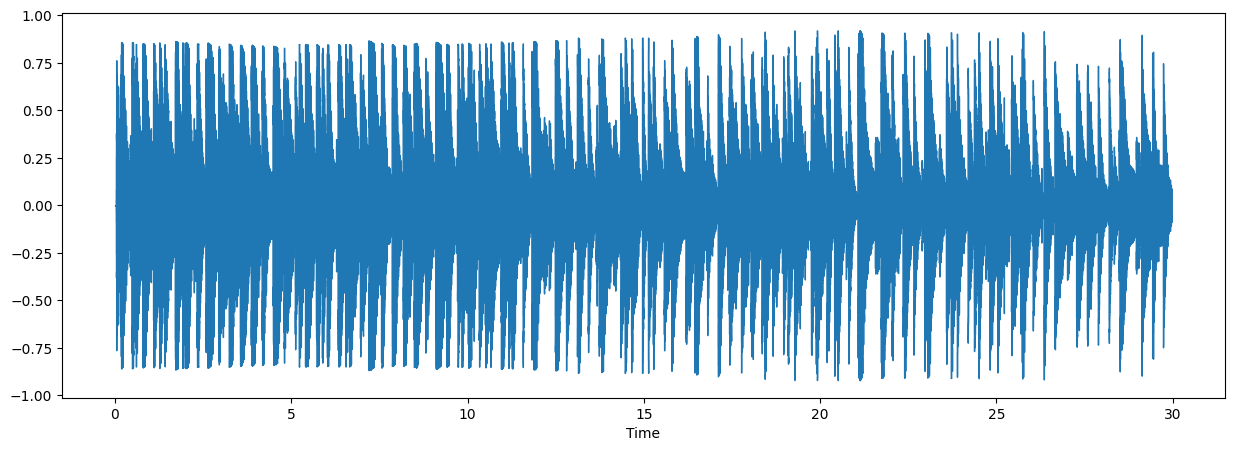

In [16]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y)
plt.show()

In [22]:
len(librosa.feature.zero_crossing_rate(y)[0])

1291

# Spectral Features
## Chromagram

In [43]:
# Calculate chroma Features from waveform
chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=20)

# Use an energy (magnitude) spectrum instead of power spectrogram
# S = np.abs(librosa.stft(y))
# chroma = librosa.feature.chroma_stft(S=S, sr=sr)

# Use a pre-computed power spectrogram with a larger frame
# S = np.abs(librosa.stft(y, n_fft=4096))**2
# chroma = librosa.feature.chroma_stft(S=S, sr=sr)

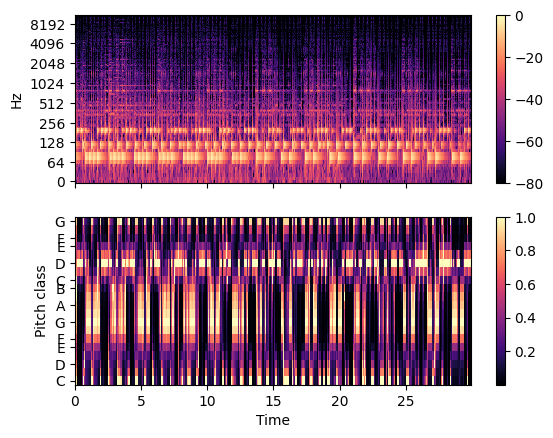

In [44]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                               y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].label_outer()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
plt.show()

## Constant-Q chromagram

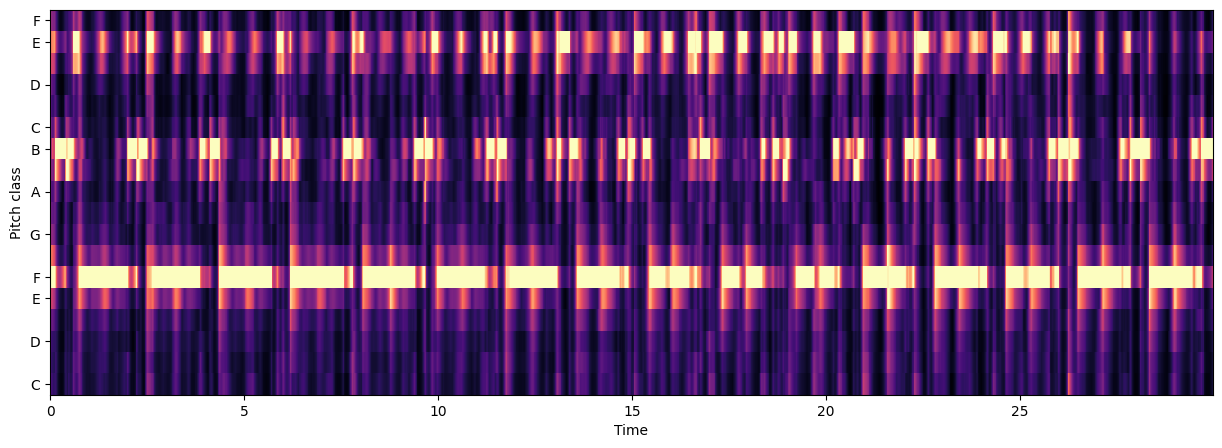

In [59]:
chroma = librosa.feature.chroma_cqt(y=y, sr=sr, n_chroma=18)

plt.figure(figsize=(15, 5))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.show()

## Chroma Energy Normalized
Compute the chroma variant “Chroma Energy Normalized” (CENS). To compute CENS features, following steps are taken after obtaining chroma vectors using chroma_cqt:
1. L-1 normalization of each chroma vector
2. Quantization of amplitude based on “log-like” amplitude thresholds
3. (optional) Smoothing with sliding window. Default window length = 41 frames
4. (not implemented) Downsampling

CENS features are robust to dynamics, timbre and articulation, thus these are commonly used in audio matching and retrieval applications.

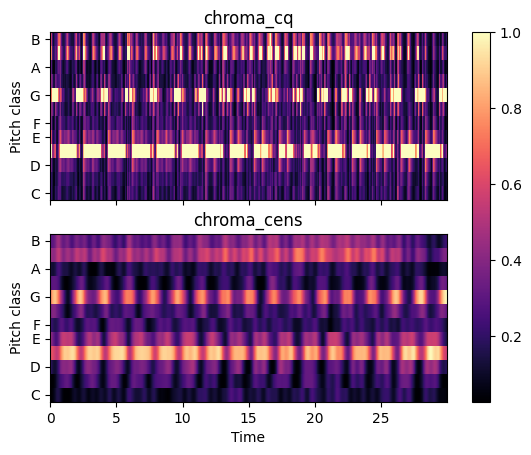

In [60]:
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
img = librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].set(title='chroma_cq')
ax[0].label_outer()
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='chroma_cens')
fig.colorbar(img, ax=ax)

## Variable-Q chromagram
This differs from CQT-based chroma by supporting non-equal temperament intervals.

Note: unlike CQT- and STFT-based chroma, VQT chroma does not aggregate energy from neighboring frequency bands. As a result, the number of chroma features produced is equal to the number of intervals used, or equivalently, the number of bins per octave in the underlying VQT representation.

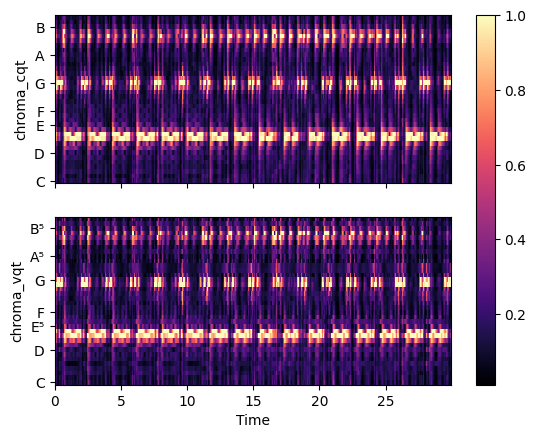

In [61]:
n_bins = 36
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr, n_chroma=n_bins)
chroma_vq = librosa.feature.chroma_vqt(y=y, sr=sr, intervals='ji5', bins_per_octave=n_bins)

fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time',
                         ax=ax[0], bins_per_octave=n_bins)
ax[0].set(ylabel='chroma_cqt')
ax[0].label_outer()
img = librosa.display.specshow(chroma_vq, y_axis='chroma_fjs', x_axis='time',
                               ax=ax[1], bins_per_octave=n_bins,
                               intervals='ji5')
ax[1].set(ylabel='chroma_vqt')
fig.colorbar(img, ax=ax)

## Mel-scaled spectrogram
If a spectrogram input S is provided, then it is mapped directly onto the mel basis by mel_f.dot(S).

If a time-series input y, sr is provided, then its magnitude spectrogram S is first computed, and then mapped onto the mel scale by mel_f.dot(S**power).

By default, power=2 operates on a power spectrum.

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

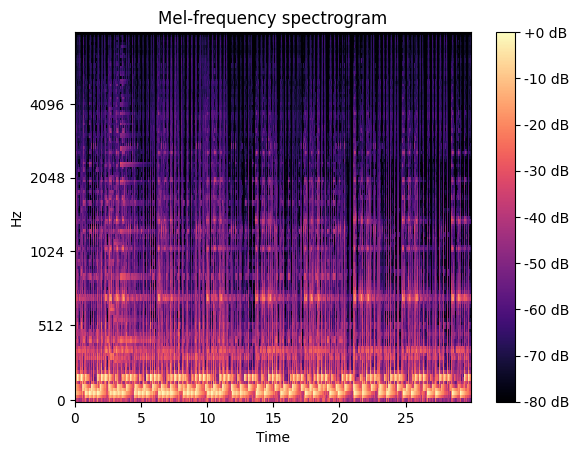

In [62]:
S = librosa.feature.melspectrogram(y=y, sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

## MFCC
Mel-frequency cepstral coefficients

If multi-channel audio input y is provided, the MFCC calculation will depend on the peak loudness (in decibels) across all channels. The result may differ from independent MFCC calculation of each channel.

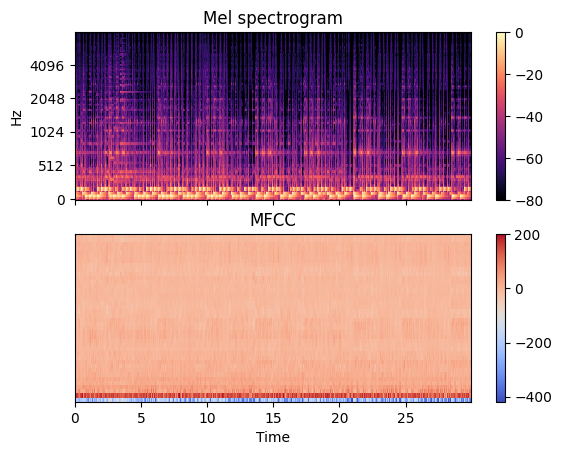

(40, 1291)

In [65]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')
plt.show()
mfccs.shape

## Rms
Compute root-mean-square (RMS) value for each frame, either from the audio samples y or from a spectrogram S.

Computing the RMS value from audio samples is faster as it doesn’t require a STFT calculation. However, using a spectrogram will give a more accurate representation of energy over time because its frames can be windowed, thus prefer using S if it’s already available.

[Text(0.5, 1.0, 'log Power spectrogram')]

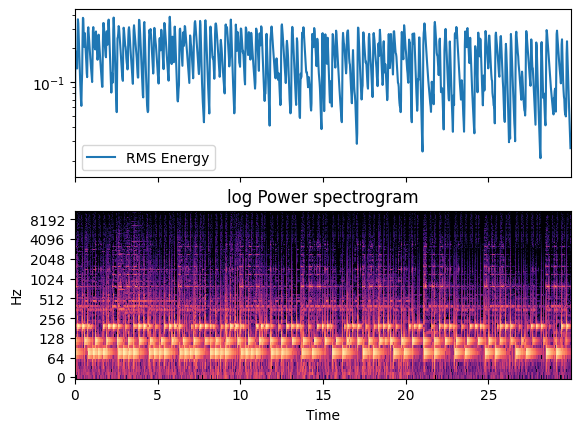

In [66]:
S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(S=S)

fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

## Spectral centroid
Each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.

More precisely, the centroid at frame t is defined as 1:
`centroid[t] = sum_k S[k, t] * freq[k] / (sum_j S[j, t])`
where S is a magnitude spectrogram, and freq is the array of frequencies (e.g., FFT frequencies in Hz) of the rows of S.

[Text(0.5, 1.0, 'log Power spectrogram')]

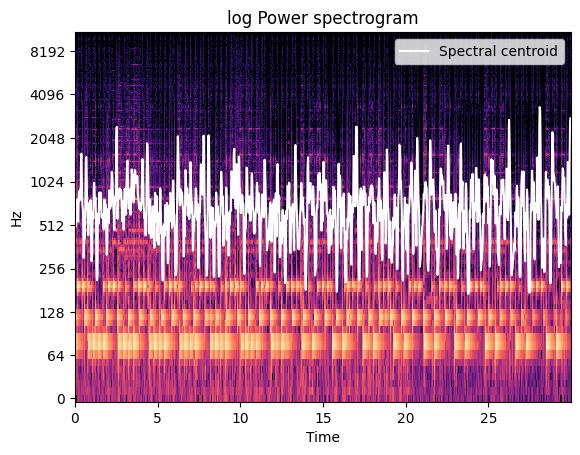

In [67]:
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
S, phase = librosa.magphase(librosa.stft(y=y))
freqs, times, D = librosa.reassigned_spectrogram(y, fill_nan=True)

times = librosa.times_like(cent)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, cent.T, label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Power spectrogram')

## P’th-order spectral bandwidth
The spectral bandwidth 1 at frame t is computed by:

`(sum_k S[k, t] * (freq[k, t] - centroid[t])**p)**(1/p)`

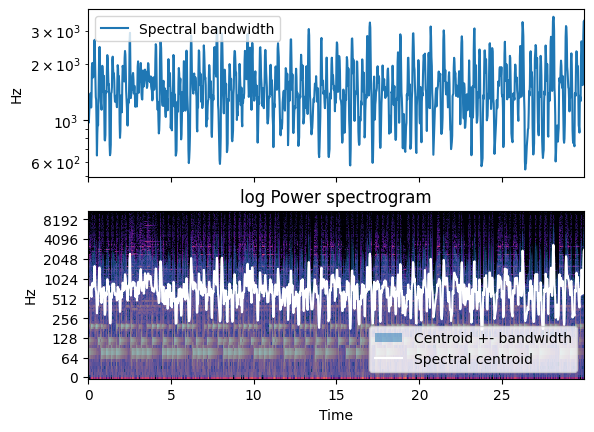

In [68]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
freqs, times, D = librosa.reassigned_spectrogram(y, fill_nan=True)

fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(spec_bw)
centroid = librosa.feature.spectral_centroid(S=S)
ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
ax[1].fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]),
                np.minimum(centroid[0] + spec_bw[0], sr/2),
                alpha=0.5, label='Centroid +- bandwidth')
ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')

## Spectral contrast
Each frame of a spectrogram S is divided into sub-bands. For each sub-band, the energy contrast is estimated by comparing the mean energy in the top quantile (peak energy) to that of the bottom quantile (valley energy). High contrast values generally correspond to clear, narrow-band signals, while low contrast values correspond to broad-band noise. 

[Text(0, 0.5, 'Frequency bands'), Text(0.5, 1.0, 'Spectral contrast')]

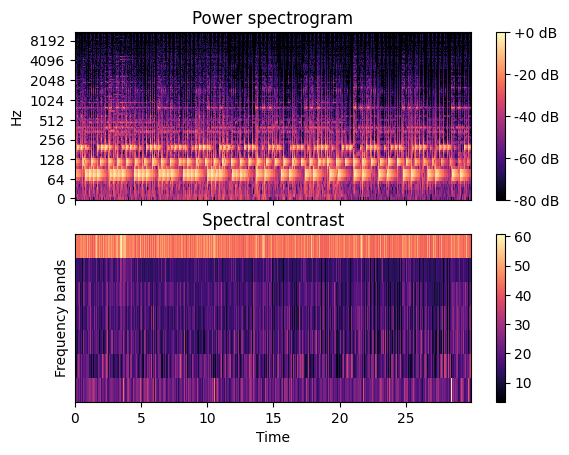

In [69]:
S = np.abs(librosa.stft(y))
contrast = librosa.feature.spectral_contrast(S=S, sr=sr)

fig, ax = plt.subplots(nrows=2, sharex=True)
img1 = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                 ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img1, ax=[ax[0]], format='%+2.0f dB')
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
img2 = librosa.display.specshow(contrast, x_axis='time', ax=ax[1])
fig.colorbar(img2, ax=[ax[1]])
ax[1].set(ylabel='Frequency bands', title='Spectral contrast')

## Spectral flatness
Spectral flatness (or tonality coefficient) is a measure to quantify how much noise-like a sound is, as opposed to being tone-like 1. A high spectral flatness (closer to 1.0) indicates the spectrum is similar to white noise. It is often converted to decibel.

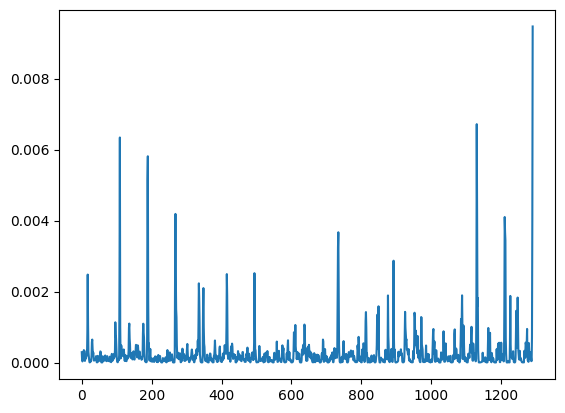

In [77]:
flatness = librosa.feature.spectral_flatness(y=y)

plt.plot(flatness.T)
plt.show()

## Roll-off frequency
The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below. This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent to a value close to 1 (or 0).

[Text(0.5, 1.0, 'log Power spectrogram')]

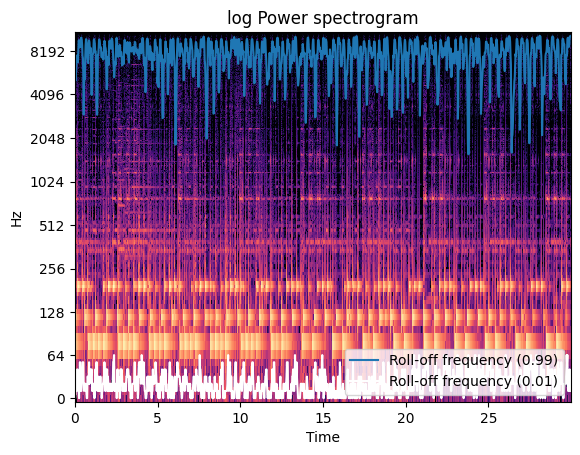

In [78]:
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.99)
rolloff_min = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)

fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.99)')
ax.plot(librosa.times_like(rolloff), rolloff_min[0], color='w',
        label='Roll-off frequency (0.01)')
ax.legend(loc='lower right')
ax.set(title='log Power spectrogram')

## Coefficients of fitting an nth-order polynomia
Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram.

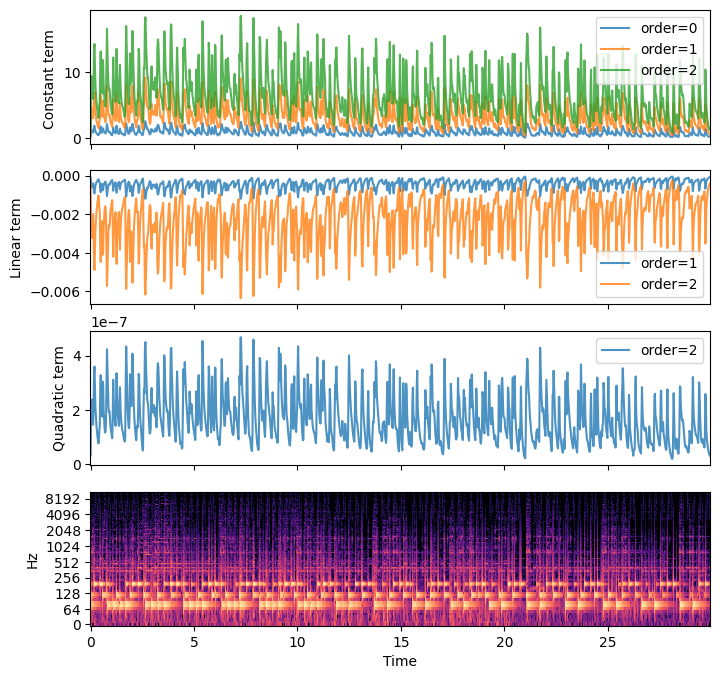

In [79]:
S = np.abs(librosa.stft(y))
p0 = librosa.feature.poly_features(S=S, order=0)
p1 = librosa.feature.poly_features(S=S, order=1)
p2 = librosa.feature.poly_features(S=S, order=2)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 8))
times = librosa.times_like(p0)
ax[0].plot(times, p0[0], label='order=0', alpha=0.8)
ax[0].plot(times, p1[1], label='order=1', alpha=0.8)
ax[0].plot(times, p2[2], label='order=2', alpha=0.8)
ax[0].legend()
ax[0].label_outer()
ax[0].set(ylabel='Constant term ')
ax[1].plot(times, p1[0], label='order=1', alpha=0.8)
ax[1].plot(times, p2[1], label='order=2', alpha=0.8)
ax[1].set(ylabel='Linear term')
ax[1].label_outer()
ax[1].legend()
ax[2].plot(times, p2[0], label='order=2', alpha=0.8)
ax[2].set(ylabel='Quadratic term')
ax[2].legend()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[3])

## Tonal centroid features
This representation uses the method of 1 to project chroma features onto a 6-dimensional basis representing the perfect fifth, minor third, and major third each as two-dimensional coordinates.

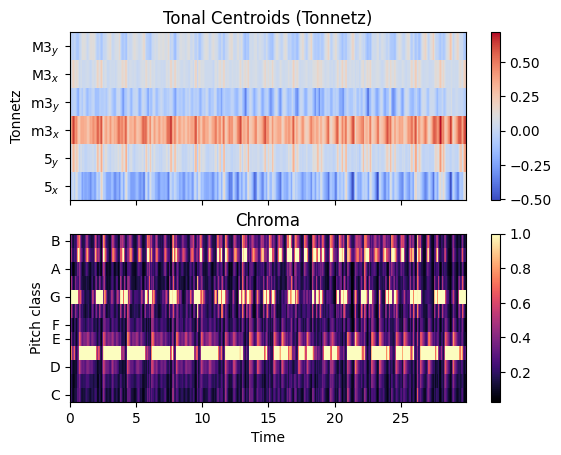

In [80]:
y_h = librosa.effects.harmonic(y)
tonnetz = librosa.feature.tonnetz(y=y_h, sr=sr)

fig, ax = plt.subplots(nrows=2, sharex=True)
img1 = librosa.display.specshow(tonnetz,
                                y_axis='tonnetz', x_axis='time', ax=ax[0])
ax[0].set(title='Tonal Centroids (Tonnetz)')
ax[0].label_outer()
img2 = librosa.display.specshow(librosa.feature.chroma_cqt(y=y, sr=sr),
                                y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='Chroma')
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])

## Zero-crossing rate 

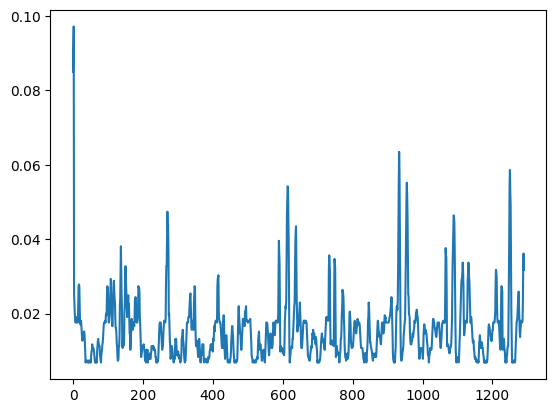

In [82]:
plt.plot(librosa.feature.zero_crossing_rate(y).T)

# Rythm Features
## Tempo

In [84]:
# Estimate a static tempo
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr)
tempo

array([184.5703125])

In [85]:
# Or a static tempo with a uniform prior instead
import scipy.stats
prior = scipy.stats.uniform(30, 300)  # uniform over 30-300 BPM
utempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr, prior=prior)
utempo

array([184.5703125])

[184.5703125 184.5703125 184.5703125 ...  95.703125   95.703125
  95.703125 ]


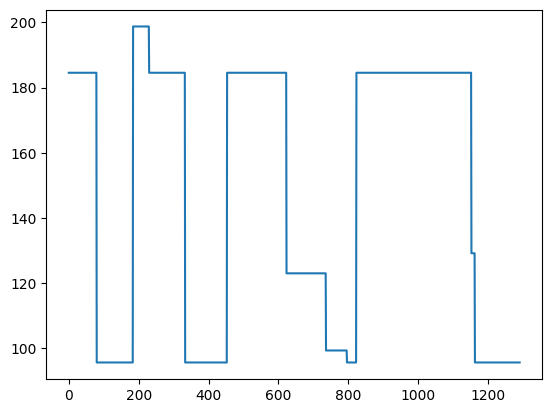

In [89]:
# Or a dynamic tempo
dtempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr,
                               aggregate=None)

print(dtempo)
plt.plot(dtempo)

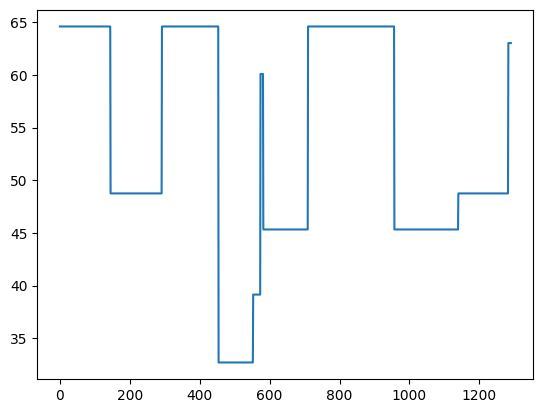

In [90]:
# Dynamic tempo with a proper log-normal prior
prior_lognorm = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)
dtempo_lognorm = librosa.feature.tempo(onset_envelope=onset_env, sr=sr,
                                       aggregate=None,
                                       prior=prior_lognorm)
plt.plot(dtempo_lognorm)

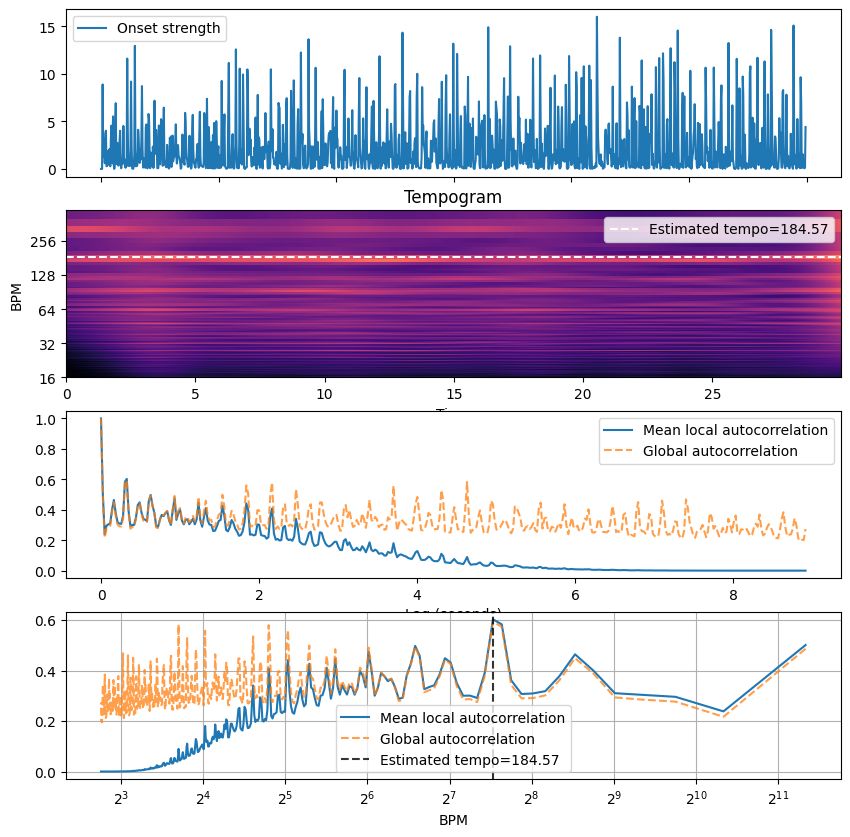

In [94]:
hop_length = 512
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                      hop_length=hop_length)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.feature.tempo(onset_envelope=oenv, sr=sr,
                              hop_length=hop_length)[0]


fig, ax = plt.subplots(nrows=4, figsize=(10, 10))
times = librosa.times_like(oenv, sr=sr, hop_length=hop_length)
ax[0].plot(times, oenv, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='magma',
                         ax=ax[1])
ax[1].axhline(tempo, color='w', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
ax[1].legend(loc='upper right')
ax[1].set(title='Tempogram')
x = np.linspace(0, tempogram.shape[0] * float(hop_length) / sr,
                num=tempogram.shape[0])
ax[2].plot(x, np.mean(tempogram, axis=1), label='Mean local autocorrelation')
ax[2].plot(x, ac_global, '--', alpha=0.75, label='Global autocorrelation')
ax[2].set(xlabel='Lag (seconds)')
ax[2].legend(frameon=True)
freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)
ax[3].semilogx(freqs[1:], np.mean(tempogram[1:], axis=1),
             label='Mean local autocorrelation', base=2)
ax[3].semilogx(freqs[1:], ac_global[1:], '--', alpha=0.75,
             label='Global autocorrelation', base=2)
ax[3].axvline(tempo, color='black', linestyle='--', alpha=.8,
            label='Estimated tempo={:g}'.format(tempo))
ax[3].legend(frameon=True)
ax[3].set(xlabel='BPM')
ax[3].grid(True)

## Fourier tempogram
Compute the Fourier tempogram: the short-time Fourier transform of the onset strength envelope.

[Text(0.5, 1.0, 'Autocorrelation tempogram')]

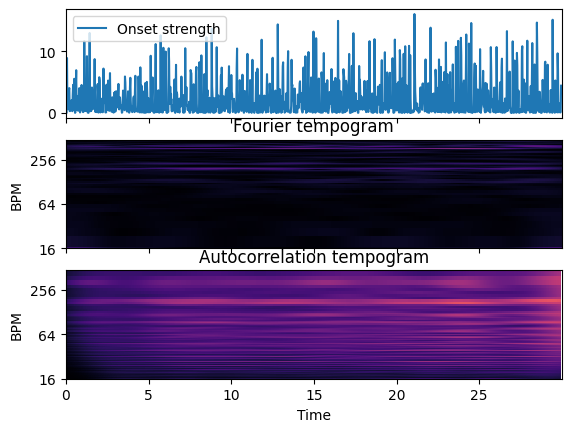

In [95]:
# Compute local onset autocorrelation
hop_length = 512
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr,
                                              hop_length=hop_length)
# Compute the auto-correlation tempogram, unnormalized to make comparison easier
ac_tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                         hop_length=hop_length, norm=None)

fig, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(librosa.times_like(oenv), oenv, label='Onset strength')
ax[0].legend(frameon=True)
ax[0].label_outer()
librosa.display.specshow(np.abs(tempogram), sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='fourier_tempo', cmap='magma',
                         ax=ax[1])
ax[1].set(title='Fourier tempogram')
ax[1].label_outer()
librosa.display.specshow(ac_tempogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='magma',
                         ax=ax[2])
ax[2].set(title='Autocorrelation tempogram')                                         

## Tempogram ratio
Tempogram ratio features, also known as spectral rhythm patterns. [1]

This function summarizes the energy at metrically important multiples of the tempo. For example, if the tempo corresponds to the quarter-note period, the tempogram ratio will measure the energy at the eighth note, sixteenth note, half note, whole note, etc. periods, as well as dotted and triplet ratios.

By default, the multiplicative factors used here are as specified by [2]. If the estimated tempo corresponds to a quarter note, these factors will measure relative energy at the following metrical subdivisions:

[Text(0.5, 1.0, 'Tempogram ratio')]

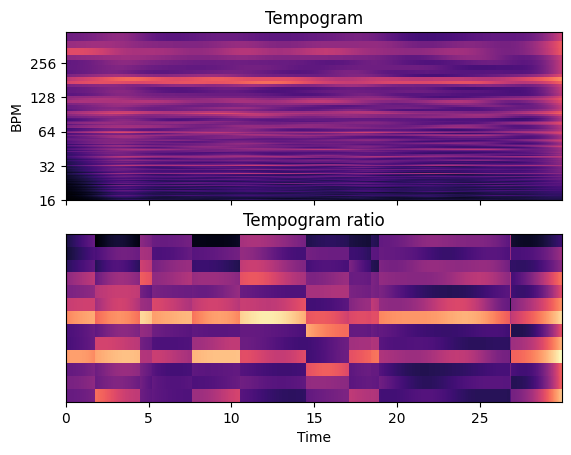

In [97]:
tempogram = librosa.feature.tempogram(y=y, sr=sr)
tgr = librosa.feature.tempogram_ratio(tg=tempogram, sr=sr)
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(tempogram, x_axis='time', y_axis='tempo',
                         ax=ax[0])
librosa.display.specshow(tgr, x_axis='time', ax=ax[1])
ax[0].label_outer()
ax[0].set(title="Tempogram")
ax[1].set(title="Tempogram ratio")

# Feature manipulation
## delta
Compute delta features: local estimate of the derivative of the input data along the selected axis.

Delta features are computed Savitsky-Golay filtering.

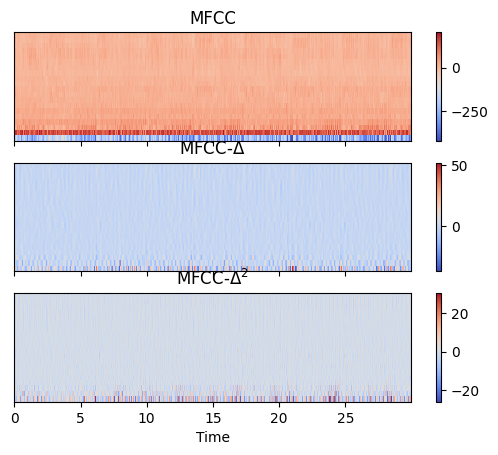

In [99]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img1 = librosa.display.specshow(mfcc, ax=ax[0], x_axis='time')
ax[0].set(title='MFCC')
ax[0].label_outer()
img2 = librosa.display.specshow(mfcc_delta, ax=ax[1], x_axis='time')
ax[1].set(title=r'MFCC-$\Delta$')
ax[1].label_outer()
img3 = librosa.display.specshow(mfcc_delta2, ax=ax[2], x_axis='time')
ax[2].set(title=r'MFCC-$\Delta^2$')
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])
fig.colorbar(img3, ax=[ax[2]])

# Onset
## Onset detection
Locate note onset events by picking peaks in an onset strength envelope.

The peak_pick parameters were chosen by large-scale hyper-parameter optimization over the dataset provided by

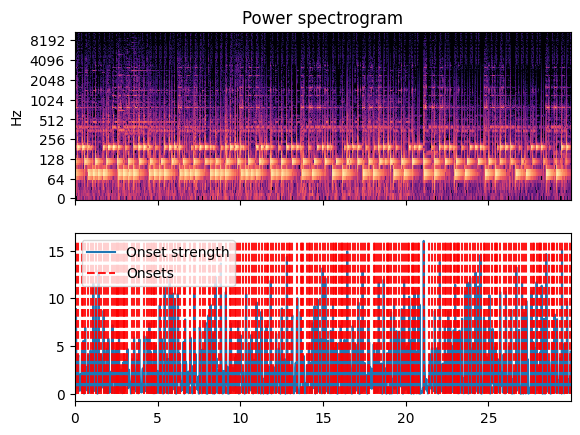

In [100]:
# librosa.onset.onset_detect(y=y, sr=sr, units='time')

o_env = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
ax[1].legend()

## Backtrack onset
Backtrack detected onset events to the nearest preceding local minimum of an energy function.

This function can be used to roll back the timing of detected onsets from a detected peak amplitude to the preceding minimum.

This is most useful when using onsets to determine slice points for segmentation, as described by.

In [105]:
oenv = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.times_like(oenv, sr=sr)
# Detect events without backtracking

onset_raw = librosa.onset.onset_detect(onset_envelope=oenv,
                                       backtrack=False)
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)

In [106]:
S = np.abs(librosa.stft(y=y))
rms = librosa.feature.rms(S=S)
onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])

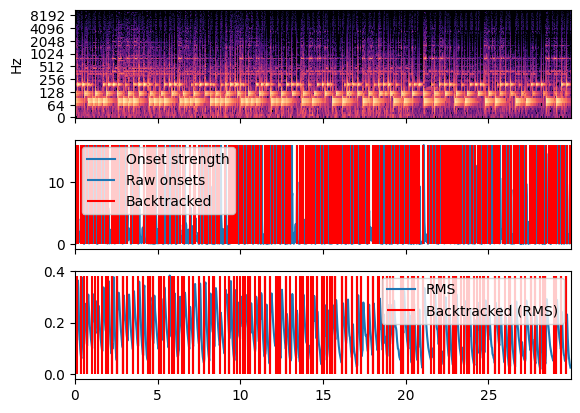

In [107]:
fig, ax = plt.subplots(nrows=3, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
ax[0].label_outer()
ax[1].plot(times, oenv, label='Onset strength')
ax[1].vlines(librosa.frames_to_time(onset_raw), 0, oenv.max(), label='Raw onsets')
ax[1].vlines(librosa.frames_to_time(onset_bt), 0, oenv.max(), label='Backtracked', color='r')
ax[1].legend()
ax[1].label_outer()
ax[2].plot(times, rms[0], label='RMS')
ax[2].vlines(librosa.frames_to_time(onset_bt_rms), 0, rms.max(), label='Backtracked (RMS)', color='r')
ax[2].legend()

## Onset strength
Compute a spectral flux onset strength envelope.

Onset strength at time t is determined by:

`mean_f max(0, S[f, t] - ref[f, t - lag])`
where ref is S after local max filtering along the frequency axis 1.

By default, if a time series y is provided, S will be the log-power Mel spectrogram.

[Text(0, 0.5, 'Normalized strength'), []]

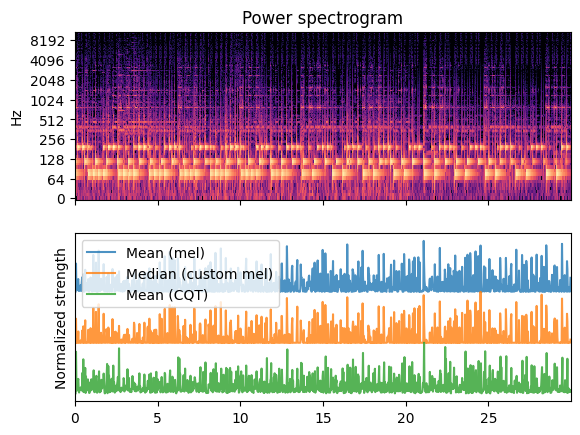

In [114]:
D = np.abs(librosa.stft(y))
times = librosa.times_like(D, sr=sr)
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()

# Construct a standard onset function
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
ax[1].plot(times, 2 + onset_env / onset_env.max(), alpha=0.8,
           label='Mean (mel)')

# Median aggregation, and custom mel options
onset_env = librosa.onset.onset_strength(y=y, sr=sr,
                                         aggregate=np.median,
                                         fmax=8000, n_mels=256)
ax[1].plot(times, 1 + onset_env / onset_env.max(), alpha=0.8,
           label='Median (custom mel)')

#Constant-Q spectrogram instead of Mel
C = np.abs(librosa.cqt(y=y, sr=sr))
onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
ax[1].plot(times, onset_env / onset_env.max(), alpha=0.8,
         label='Mean (CQT)')
ax[1].legend()
ax[1].set(ylabel='Normalized strength', yticks=[])

## Onset strength envelope across multiple channels
Compute a spectral flux onset strength envelope across multiple channels.

Onset strength for channel i at time t is determined by:

`mean_{f in channels[i]} max(0, S[f, t+1] - S[f, t])`

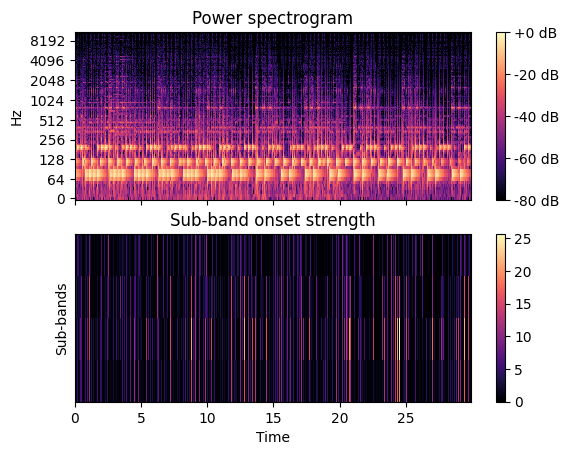

In [116]:
D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=2, sharex=True)
img1 = librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
fig.colorbar(img1, ax=[ax[0]], format="%+2.f dB")

# Construct a standard onset function over four sub-bands
onset_subbands = librosa.onset.onset_strength_multi(y=y, sr=sr,
                                                    channels=[0, 32, 64, 96, 128])
img2 = librosa.display.specshow(onset_subbands, x_axis='time', ax=ax[1])
ax[1].set(ylabel='Sub-bands', title='Sub-band onset strength')
fig.colorbar(img2, ax=[ax[1]])

# Beat and Tempo
## beat tracker
Dynamic programming beat tracker.

Beats are detected in three stages, following the method of 1:
1. Measure onset strength
2. Estimate tempo from onset correlation
3. Pick peaks in onset strength approximately consistent with estimated tempo

In [117]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
print(tempo)
print(beats)

[198.76802885]
[   5   19   34   48   62   75   88  102  115  128  141  155  168  181
  194  207  221  234  247  260  274  287  301  314  327  340  353  366
  380  393  406  420  433  446  460  473  486  499  511  524  538  552
  566  579  592  605  619  632  645  659  672  684  697  709  723  737
  749  764  778  791  804  818  831  844  857  871  884  897  910  924
  937  950  964  977  990 1003 1016 1029 1043 1056 1068 1080 1093 1107
 1122 1136 1149 1164 1176 1189 1202 1215 1228 1242 1255 1268 1279]


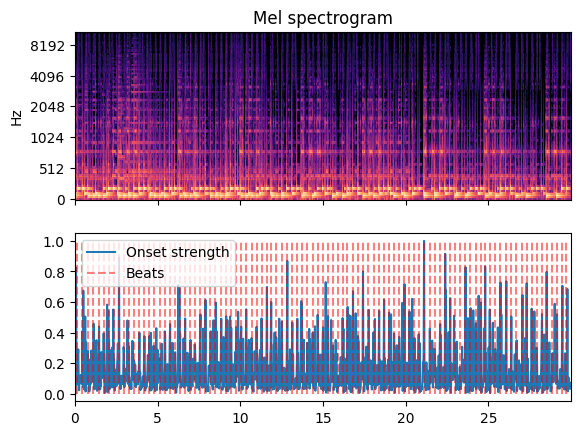

In [123]:
hop_length = 512
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[0])
ax[0].label_outer()
ax[0].set(title='Mel spectrogram')
ax[1].plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats')
ax[1].legend()

## Predominant local pulse
The PLP method analyzes the onset strength envelope in the frequency domain to find a locally stable tempo for each frame. These local periodicities are used to synthesize local half-waves, which are combined such that peaks coincide with rhythmically salient frames (e.g. onset events on a musical time grid). The local maxima of the pulse curve can be taken as estimated beat positions.

This method may be preferred over the dynamic programming method of beat_track when the tempo is expected to vary significantly over time. Additionally, since plp does not require the entire signal to make predictions, it may be preferable when beat-tracking long recordings in a streaming setting.

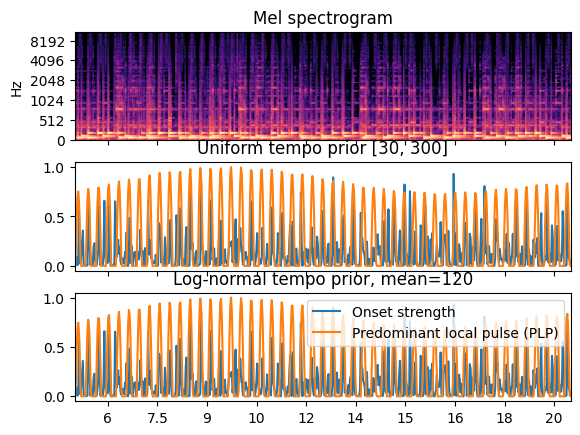

In [125]:
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr)
# Or compute pulse with an alternate prior, like log-normal
import scipy.stats
prior = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)
pulse_lognorm = librosa.beat.plp(onset_envelope=onset_env, sr=sr,
                                 prior=prior)
melspec = librosa.feature.melspectrogram(y=y, sr=sr)

fig, ax = plt.subplots(nrows=3, sharex=True)
librosa.display.specshow(librosa.power_to_db(melspec,
                                             ref=np.max),
                         x_axis='time', y_axis='mel', ax=ax[0])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
ax[1].plot(librosa.times_like(onset_env),
         librosa.util.normalize(onset_env),
         label='Onset strength')
ax[1].plot(librosa.times_like(pulse),
         librosa.util.normalize(pulse),
         label='Predominant local pulse (PLP)')
ax[1].set(title='Uniform tempo prior [30, 300]')
ax[1].label_outer()
ax[2].plot(librosa.times_like(onset_env),
         librosa.util.normalize(onset_env),
         label='Onset strength')
ax[2].plot(librosa.times_like(pulse_lognorm),
         librosa.util.normalize(pulse_lognorm),
         label='Predominant local pulse (PLP)')
ax[2].set(title='Log-normal tempo prior, mean=120', xlim=[5, 20])
ax[2].legend()

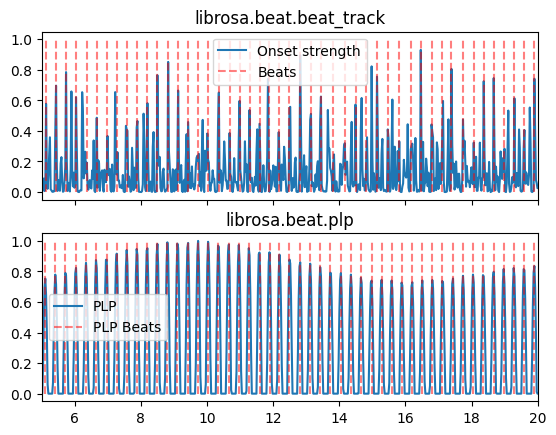

In [126]:
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env)
beats_plp = np.flatnonzero(librosa.util.localmax(pulse))
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
times = librosa.times_like(onset_env, sr=sr)
ax[0].plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
ax[0].vlines(times[beats], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats')
ax[0].legend()
ax[0].set(title='librosa.beat.beat_track')
ax[0].label_outer()
# Limit the plot to a 15-second window
times = librosa.times_like(pulse, sr=sr)
ax[1].plot(times, librosa.util.normalize(pulse),
         label='PLP')
ax[1].vlines(times[beats_plp], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='PLP Beats')
ax[1].legend()
ax[1].set(title='librosa.beat.plp', xlim=[5, 20])
ax[1].xaxis.set_major_formatter(librosa.display.TimeFormatter())

In [132]:
librosa.util.normalize(pulse)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

# Spectrogram decomposition
## Median-filtering harmonic percussive source separation
If margin = 1.0, decomposes an input spectrogram S = H + P where H contains the harmonic components, and P contains the percussive components.

If margin > 1.0, decomposes an input spectrogram S = H + P + R where R contains residual components not included in H or P.

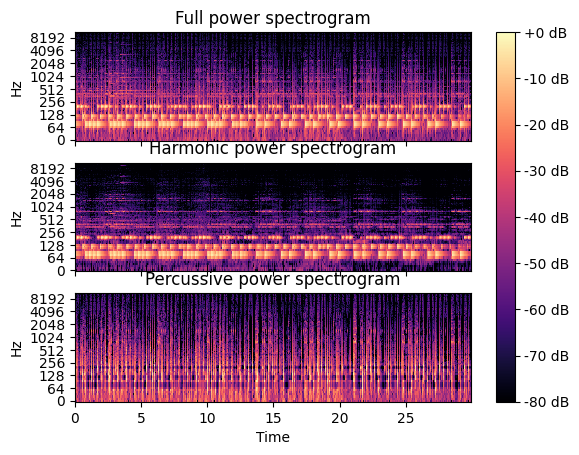

In [133]:
D = librosa.stft(y)
H, P = librosa.decompose.hpss(D)

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(D),
                                                       ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Full power spectrogram')
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(H),
                                                 ref=np.max(np.abs(D))),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Harmonic power spectrogram')
ax[1].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(P),
                                                 ref=np.max(np.abs(D))),
                         y_axis='log', x_axis='time', ax=ax[2])
ax[2].set(title='Percussive power spectrogram')
fig.colorbar(img, ax=ax, format='%+2.0f dB')

# Effects

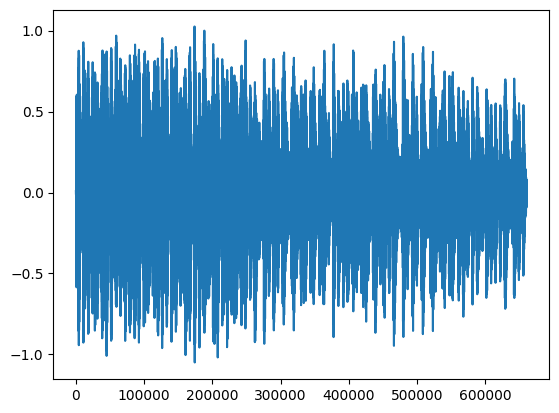

In [142]:
y_harmonic = librosa.effects.harmonic(y)
plt.plot(y_harmonic)

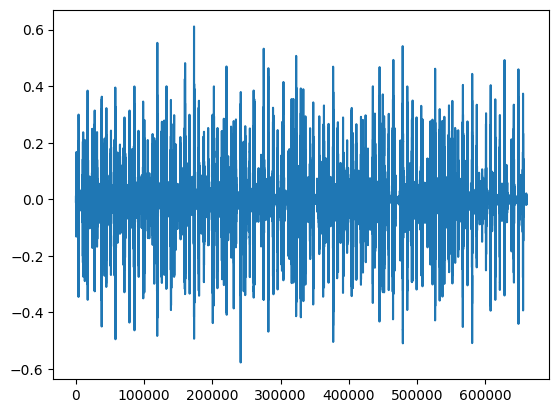

In [141]:
y_percussive = librosa.effects.percussive(y)
plt.plot(y_percussive)

In [145]:
from tqdm import tqdm
import os


rootdir = '../datasets/fma/fma_small/'

valid = []

total_files = sum([len(files) for r, d, files in os.walk(rootdir)])

with tqdm(total=total_files, desc="Processing files") as pbar:
    for subdir, dirs, folders in os.walk(rootdir):
        for folder in dirs:
            for subdir_, dirs, files in os.walk(os.path.join(rootdir, folder)):
                for file in files:
                    path = os.path.join(subdir_, file)
                    try:
                        y, sr = librosa.load(path)
                        valid.append(librosa.util.valid_audio(y))
                    except Exception as e:
                        print(f"Error processing {path}: {e}. Deleting the file.")
                    pbar.update(1)

Processing files: 100%|█████████▉| 7994/7996 [08:17<00:00, 16.08it/s]


In [148]:
len(valid)-sum(valid)

0